In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [4]:
df = pd.read_csv("../data/mlbootcamp5_train.csv", 
                 sep=";", 
                 index_col="id")
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [8]:
class Tree:
    
    def __init__(self):
        
        self.vertices_number = 0
        self.vertices = []
        self.depth = 0
        self.root = None
        
    def addNode(self, data, possible_features, depth, parent = None):
        
        new_node = Tree_node(parent = parent, data = data, possible_features=possible_features, depth = depth)
        
        if self.vertices_number == 0:
            
            self.root = new_node
            
        if parent is not None:
            parent.children.append(new_node)
        
        self.vertices.append(new_node)
        self.vertices_number += 1
        new_node.index = self.vertices_number
        
        return new_node
    
    def print(self):
        
        for node in self.vertices:
            
            print(node)
            

In [9]:
class Tree_node:
    
    def __init__(self, data, possible_features, depth, parent = None):
        
        self.parent = parent
        self.children = []
        self.type = 'node'
        self.prediction = None
        self.data = data
        self.feature = None
        self.gini = None
        self.possible_features = possible_features
        self.index = None
        self.p_0 = None
        self.p_1 = None
        self.depth = depth
        
    def calculate_gini(self, target_feature, data = None):
        
        if data is None:
            data = self.data
            
        p = (data[target_feature] == 0).sum() / data[target_feature].shape[0]
        q = (data[target_feature] == 1).sum() / data[target_feature].shape[0]
        
        return (1 - p**2 - q**2)
        
    def find_best_partition(self, target_feature, features):

        best = None
        best_gini = 50
        
        if len(self.possible_features):

            for f in self.possible_features:

                for i in range(2):
                    
                    partition_i = self.data[self.data[f] == i]

                    g = self.calculate_gini(data = partition_i, target_feature=target_feature)

                    if g < best_gini:

                        best = f
                        best_gini = g

            return(best)
        
        else:
            return(None)
    
    
    def set_class(self, target):
        
        self.p_0 = (self.data[target] == 0).sum() / len(self.data[target])
        self.p_1 = (self.data[target] == 1).sum() / len(self.data[target])
        
        return (int(self.p_1 > self.p_0))
    
    def __str__(self):
        
        s = ''
          
        s += 'Gini: ' + str(round(self.gini, 6)) + '\\n'
        if self.type == 'leaf':
            s += 'Class 0 proba: ' + str(round(self.p_0, 2)) + '\\n '
            s += 'Class 1 proba: ' + str(round(self.p_1, 2)) + '\\n' 
        if self.feature is not None: s += 'Feature: ' + str(self.feature) + '\\n'
        if self.prediction is not None: s+= 'Class: ' + str(self.prediction) + '\\n'
        
        return(s)
        

In [10]:
class DecisionTreeCategoricalClassifier:
    
    '''Builds a decision tree based on categorical features'''
    
    def __init__(self):
        
        self.max_depth_possible = 0
        self.max_depth = 0
        self.target = None
        self.data = None
        self.tree = None
        
    def fit(self, data, features, target, max_depth = 3):
        
        '''Builds a decision tree. Each node has feature with which it divides data, gini index for data inside it,
        and probabilities for classes
        
        Parametres:
        
        data : pandas data frame
        
        features : an array of features presented in data.columns which have categorical data for a classifier
        
        target : a string which represents the name of a target data column
        
        max_depth : an integer for defining maximum depth of a tree
        '''
        
        self.target = target
        self.max_depth = max_depth
        self.data = data
        
        self.features = []
        
        for f in features:
            
            one_hot_feature = pd.get_dummies(data[f], prefix = str(f))
            
            for feature in one_hot_feature:
                self.features.append(str(feature))
                        
            self.data = pd.concat([self.data, one_hot_feature], axis = 1)   
        
        self.max_depth_possible = len(self.features)
        
        tree = Tree()
        
        tree.addNode(self.data, possible_features = self.features, depth = 1)
        
        tree.depth += 1
        
        
        def create_partition(node):
            
            '''Calculates best possible partition for a current node'''
            
            node.gini = node.calculate_gini(target_feature = target)
            partition = node.find_best_partition(target_feature = target, features = node.possible_features)
            node.feature = partition
            
            return(partition)
        
        def participate(tree, node, partition):
            
            '''Actually builds a tree'''
            
            nodes = []
            
            pos_features = node.possible_features.copy()
            pos_features.remove(partition)
            
            data_0 = node.data[node.data[partition] == 0]
            data_1 = node.data[node.data[partition] == 1]
            
            got_deeper = False
            
            if data_0.shape[0] != 0:

                new_node_0 = tree.addNode(data = data_0,
                                         possible_features = pos_features,
                                         parent = node,
                                         depth = node.depth + 1)
                
                nodes.append(new_node_0)
                if new_node_0.depth >= tree.depth:
                    got_deeper = True

            if data_1.shape[0] != 0:
            
                new_node_1 = tree.addNode(data = data_1,
                                         possible_features = pos_features,
                                         parent = node,
                                         depth = node.depth + 1)
            
                nodes.append(new_node_1)
                if new_node_1.depth >= tree.depth:
                    got_deeper = True
            
            if got_deeper:
                tree.depth += 1
            
            if (node.depth >= self.max_depth) or (node.depth >= self.max_depth_possible):
                
                for node in nodes:
                    
                    node.type = 'leaf'
                    node.prediction = node.set_class(target)
                    node.gini = node.calculate_gini(target_feature = target)
            
            else:
                
                for node in nodes:
                    
                    node.gini = node.calculate_gini(target_feature = target)                   
                    partition = create_partition(node)
                    
                    if (node.gini == 0) or (partition is None):
                        
                        node.type = 'leaf'
                        node.prediction = node.set_class(target)  
                        
                    if node.type == 'node':
                        
                        participate(tree, node, partition)
                        
            
                
        
        partition = create_partition(tree.root)
        participate(tree, tree.root, partition)
        
        self.tree = tree                
               
    def save2dot(self, filename):
        
        '''Saves a builded tree in a .dot file'''
        
        def node2dot(node, file):
            
            color = ''
            
            if node.type == 'leaf':
                
                color = '#e58139ff' if node.prediction == 1 else '#399de57f'                
            
            file.write('{name} [label="{label}", color="{color}"] ;\n'.format(name = node.index,
                                                                                   label = str(node),
                                                                                  color = color))
            
            for c in node.children:
                
                file.write('{name} -> {children} ;\n'.format(name =node.index, children = c.index))
                node2dot(c, file)
        
        f = open(filename, 'w')
        
        f.write('digraph Tree {\n')
        
        node2dot(self.tree.root, f)      
        
        f.write('\n}')
                          
        f.close()
    
    def predict(self, df):
        
        '''Returns an array of predicted classes for a given dataframe
        
        Parametres:
        
        df : a pandas dataframe, which have all the columns, that were presented in training data'''
        
        data = df
        
        for f in features:
            
            one_hot_feature = pd.get_dummies(df[f], prefix = str(f))
            
            for feature in one_hot_feature:
                self.features.append(str(feature))
                        
            data = pd.concat([data, one_hot_feature], axis = 1)   
        
        def down_in_tree(data, node):
                        
            if node.type == 'leaf':
                
                return node.prediction
            
            if (data[node.feature] == 0) or len(node.children) == 1:
                return down_in_tree(data, node.children[0])
            elif data[node.feature] == 1:
                return down_in_tree(data, node.children[1])
            else:
                raise FeatureException
            
        return ( [ down_in_tree(data.iloc[i,], self.tree.root) for i in range(df.shape[0])])
    
    def cross_validate(self, data, kfolds, *args, **kwargs):
        
        '''Cross validates for a given data with a given number of folds. Returns an array of size kfolds
        with accuracy scores
        
        Parametres:
        
        data : a pandas data frame. Will be used to build a tree and predict on it
        
        kfolds : an integer to set the number of folds for data
        
        kwargs: expected "features" and "target" as function builds the tree using fit() inside'''
        
        indexes = np.linspace(0, data.shape[0], kfolds+1, dtype = np.int64)
        
        folds = [ data[ indexes[i] : indexes[i+1] ] for i in range(len(indexes) - 1) ]
        
        scores = []
        
        for i in range(kfolds):
            
            test = folds[i]
            train = pd.core.frame.DataFrame()
            
            for j in range(kfolds):
                
                if i != j:
                    
                    train = pd.concat([train, folds[j]])
                    
            self.fit(data = train, *args, **kwargs)
            pred = self.predict(test)
            
            scores.append((pred == test[target]).sum() / test.shape[0])
            
        return scores
            

In [11]:
cat_tree = DecisionTreeCategoricalClassifier()
features = ['cholesterol', 'gluc', 'gender']
target = 'cardio'

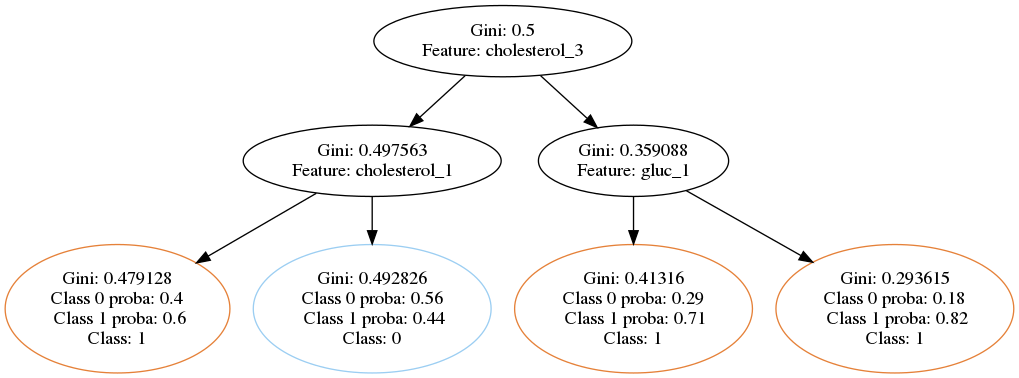

In [16]:
from IPython.display import Image

cat_tree.fit(df, features = features, target = target, max_depth = 2)

cat_tree.save2dot('graph.dot')
!dot -Tpng graph.dot -o graph.png
Image("graph.png")

Depth: 1
Accuracy: 0.5614714285714286 

Depth: 2
Accuracy: 0.5893428571428571 

Depth: 3
Accuracy: 0.5893428571428571 

Depth: 4
Accuracy: 0.5904857142857143 

Depth: 5
Accuracy: 0.5916 

Depth: 6
Accuracy: 0.5916 

Depth: 7
Accuracy: 0.5916 

Depth: 8
Accuracy: 0.5916 

Depth: 9
Accuracy: 0.5916 

Depth: 10
Accuracy: 0.5916 

5


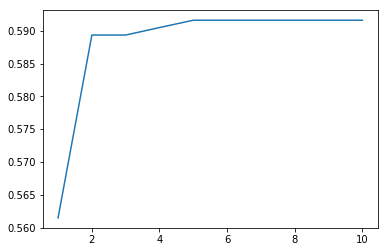

In [12]:
best_depth = 0
best_accuracy = 0
scores = []

for i in range(1, 11):
    
    cv = cat_tree.cross_validate(df, kfolds = 4, features = features, target = target, max_depth = i)
    scores.append(np.mean(cv))
    
    print('Depth:', i)
    print('Accuracy:', np.mean(cv), '\n')
    
    if np.mean(cv) > best_accuracy:
        
        best_depth = i
        best_accuracy = np.mean(cv)
    
print(best_depth)

x = np.arange(1, 11)

plt.plot(x, scores)

In [13]:
best_depth

5

In [14]:
best_accuracy

0.5916